# Fahrzeug Positionsbestimmung bei Linearer Bewegung

- Versuch 1: Positionsbestimmung mittels Beschleunigung
    - Generierte Daten
    - Gemessene Daten
- Versuch 2: Positionsbestimmung mittels GPS
    - Generierte Daten
    - Gemessene Daten

In [83]:
using LinearAlgebra, Plots, DataFrames, Distributions, CSV, Dates, GLM, StatsPlots
gr()
Plots.scalefontsizes(1.5)
upscale = 1  
default(line = (:steppre, 0.5, 1, 2), size=(800*upscale,600*upscale), fmt = :png)

## Zustand Definitionen
Zuerst werden für das Filter die Modelle definiert.
### Zustandsvektoren

$$
    x_k = 
    \begin{pmatrix}
    x \\ y \\ \dot x \\ \dot y \\ \ddot x \\ \ddot y
    \end{pmatrix}
    = 
    \begin{pmatrix}
    X Position & Y Position & v_x & v_y & acc_x & acc_y
    \end{pmatrix}
$$


### Startzustand $x_0$

$$
    x_0 =
    \begin{pmatrix}
    0 \\
    0 \\
    0 \\
    0 \\
    0 \\
    0
    \end{pmatrix}
$$

mit

$$
    \Sigma_0 = 
    \begin{pmatrix}
    \sigma _{x}^2 & 0 & 0 & 0 & 0 & 0 \\
    0 & \sigma _{y}^2 & 0 & 0 & 0 & 0 \\
    0 & 0 & \sigma _{\dot x}^2 & 0  & 0 & 0\\
    0 & 0 & 0 & \sigma _{\dot y}^2 & 0 & 0 \\
    0 & 0 & 0 & 0 & \sigma _{\ddot y}^2 & 0 \\
    0 & 0 & 0 & 0 & 0 & \sigma _{\ddot x}^2 
    \end{pmatrix}
$$

ist der Unsicherheitsmatrix (Kovarianzmatrix) in Schritt $k = 0$ mit $\sigma$ Standardabweichung.


Mit Formeln aus Physik ergibt die Gleichung $ x_{k+1} = Ax_k$:


$$
    x_{k+1} = 
    \begin{pmatrix}
    1 & 0 & \Delta t & 0 & \frac{1}{2}\Delta t^2 & 0 \\
    0 & 1 & 0 & \Delta t & 0 & \frac{1}{2}\Delta t^2 \\
    0 & 0 & 1 & 0 & \Delta t & 0 \\
    0 & 0 & 0 & 1 & 0 & \Delta t \\
    0 & 0 & 0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 0 & 0 & 1
    \end{pmatrix}
    \begin{pmatrix}
    x \\ y \\ \dot x \\ \dot y \\ \ddot x \\ \ddot y
    \end{pmatrix}
$$


### Messmatrix $ G $

Wir messen nur die Beschleunigung $\ddot x$ und $\ddot y$ direkt.
Unsere Beobachtungsmodell ist $ y = Gx $:

$$
    y =
    \begin{pmatrix}
    0 & 0 & 0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 0 & 0 & 1
    \end{pmatrix}
    *
    x
$$
Das bedeutet wir beobachten die Beschleunigung in der richtigen Einheit.



### Messrauschen Kovarianz $R$

R zeigt, wie genau die Messung war und hat die Dimension 2.

$$
    R =
    \begin{pmatrix}
    \sigma_{\dot x}^2 & 0 \\
    0 & \sigma_{\dot y}^2
    \end{pmatrix}
$$

### Prozessrauschen Kovarianzmatrix $Q$

Die Position des Fahrzeugs wird von äußeren Faktoren beeinflusst, wie z. B. der Wind oder rutschige Fahrbahn. Dies kann man mithilfe des Kovarianzmatrixes $Q$ modelliert werden.

$$
    Q = \begin{pmatrix}\sigma_{x}^2 & \sigma_{xy} & \sigma_{x \dot x} & \sigma_{x \dot y} \\ \sigma_{yx} & \sigma_{y}^2 & \sigma_{y \dot x} & \sigma_{y \dot y} \\ \sigma_{\dot x x} & \sigma_{\dot x y} & \sigma_{\dot x}^2 & \sigma_{\dot x \dot y} \\ \sigma_{\dot y x} & \sigma_{\dot y y} & \sigma_{\dot y \dot x} & \sigma_{\dot y}^2 \end{pmatrix}
$$

$Q$ kann berechnet werden als $ Q = G \cdot G^T \cdot \sigma_v^2$ mit 
$G = \begin{pmatrix}0.5dt^2 & 0.5dt^2 & dt & dt\end{pmatrix}^T$ und $\sigma_v$ als die Beschleunigungsprozessrauschen. Diese kann nach  Schubert, R., Adam, C., Obst, M., Mattern, N., Leonhardt, V., & Wanielik, G. (2011). Empirical evaluation of vehicular models for ego motion estimation als $8.8 m/s^2$ angenähert werden.

In [203]:
x_0 = zeros(6, 1)
Σ_0 = Matrix{Float64}(I, 6, 6) .* 1000

Δ_t = 0.1 # Messfrequenz war 100ms
A = [1 0 Δ_t 0 0.5*Δ_t^2 0;
     0 1 0 Δ_t 0 0.5*Δ_t^2;
     0 0 1 0 Δ_t 0;
     0 0 0 1 0 Δ_t;
     0 0 0 0 1 0;
     0 0 0 0 0 1]

G = [0 0 0 0 1 0;
     0 0 0 0 0 1]

R = [0.4 0;
     0 0.4]

σ_v = 8.8
Gravity = transpose([ 0.5 * Δ_t^2 0.5 * Δ_t^2 Δ_t Δ_t Δ_t Δ_t])
#Q = transpose(Gravity * transpose(Gravity) * σ_v^2)
Q = I * 0.001

UniformScaling{Float64}
0.001*I

## Generierung von Testdaten 

### Sensor Messungen
Es wird eine gemessene Strecke importiert. Anhand der linearen Regression ist es sichtbar, dass auf langer Sicht die Sensoren genaus sind, da die Gerade fast gleich 0 ist und außerdem bekannt ist, dass wir aus dem Stand starten und die Strecke enden.

### Sensor Daten Generieren

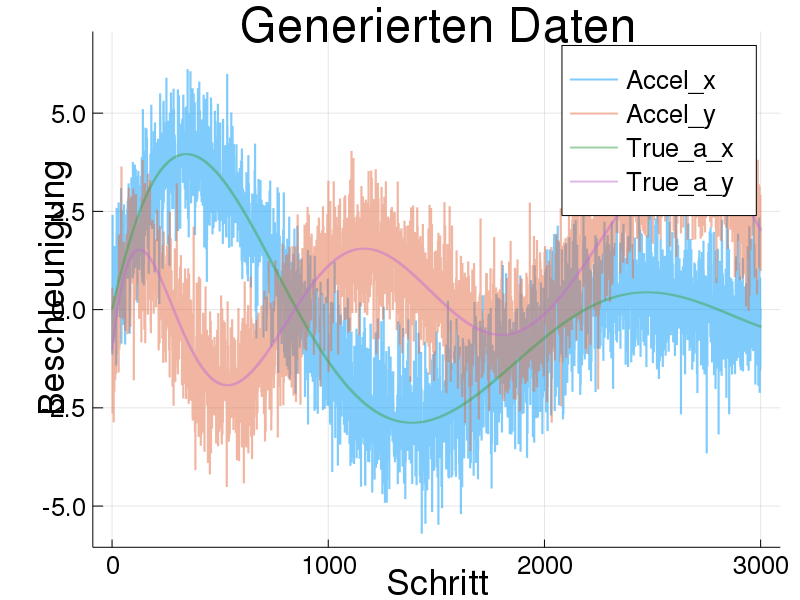

In [204]:
a_x(x) = (1.5630648346659032e-002 * x^0
     +  4.9213613999373650e-002 * x^1
     + -1.6044370168287432e-004 * x^2
     + -4.4477416588843946e-008 * x^3
     +  6.6044455557971317e-010 * x^4
     + -9.5898244697216113e-013 * x^5
     +  6.4213458863722485e-016 * x^6
     + -2.2622030848905984e-019 * x^7
     +  4.0496716020632067e-023 * x^8
     + -2.8977947947190594e-027 * x^9)

a_y(x) = (-1.0379744218802682e+000 * x^0
     +  9.7100147408547430e-002 * x^1
     + -1.1828103173413935e-003 * x^2
     +  5.2121442867146861e-006 * x^3
     + -1.0921189112845703e-008 * x^4
     +  1.1533030382011437e-011 * x^5
     + -4.7433619477931919e-015 * x^6
     + -2.1602796693012999e-018 * x^7
     +  3.6558877493288243e-021 * x^8
     + -1.9635888400267993e-024 * x^9
    +  5.4938037310170419e-028 * x^10
    + -8.0218427960112765e-032 * x^11
    +  4.8308116764392340e-036 * x^12)


function noise(array, std_deviation = 1)
    a = Normal(0, std_deviation)
    [x + rand(a) for x in array]
end
x = collect(0:0.5:1500)
generated_data = DataFrame(
    :Id => (1:size(x)[1]), 
    :Accel_x => noise(a_x.(x)), 
    :Accel_y => noise(a_y.(x)),
    :True_a_x => a_x.(x),
    :True_a_y => a_y.(x))
plot(title = "Generierten Daten", xlabel = "Schritt", ylabel = "Beschleunigung")
@df generated_data plot!(:Id, [:Accel_x :Accel_y :True_a_x :True_a_y])


Es wird Prozessrauschen und Messrauschen zu den Daten hinzugefügt.

In [205]:
first(generated_data, 6)

,Id,Accel_x,Accel_y,True_a_x,True_a_y
,Int64,Float64,Float64,Float64,Float64
1,1,0.0696956,0.560452,0.0156306,-1.03797
2,2,-1.11845,-0.856441,0.0401973,-0.989719
3,3,2.3836,-2.61533,0.0646838,-0.942052
4,4,-0.120045,-0.185909,0.0890899,-0.894968
5,5,-0.0605994,0.322076,0.113416,-0.848464
6,6,0.940494,-1.57859,0.137661,-0.802536


In [206]:
include("../KalmanFilter.jl")

Main.KalmanFilter

In [207]:
model = KalmanFilter.Kalman(A, Q, G, R, x_0, Σ_0)

n = size(generated_data)[1]
predicted = zeros(Float64, 6, n)
fusioned = zeros(Float64, 7, n)
for i = eachrow(generated_data)    
    y_cur = [i.Accel_x; i.Accel_y]
    neu = KalmanFilter.next(model, y_cur)
    fusioned[:, i.Id] = [neu.fusioned..., i.Id]
    predicted[:, i.Id] = neu.predicted
    model = neu.model
end
generated_output = DataFrame(fusioned', [:pX, :pY, :vX, :vY, :aX, :aY, :Id])
describe(generated_output)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Nothing,Nothing,DataType
1,pX,14912.5,-0.0104706,20243.2,21662.7,,,Float64
2,pY,271.102,-1707.88,-363.589,9664.4,,,Float64
3,vX,70.5674,-14.7888,34.7897,211.188,,,Float64
4,vY,32.2138,-48.0572,11.672,256.063,,,Float64
5,aX,0.00344243,-3.10363,0.0249837,4.13917,,,Float64
6,aY,0.835925,-2.1006,0.780932,4.10845,,,Float64
7,Id,1501.0,1.0,1501.0,3001.0,,,Float64


sum(abs.(generated_output.aX - generated_data.True_a_x)) = 458.11580937613957


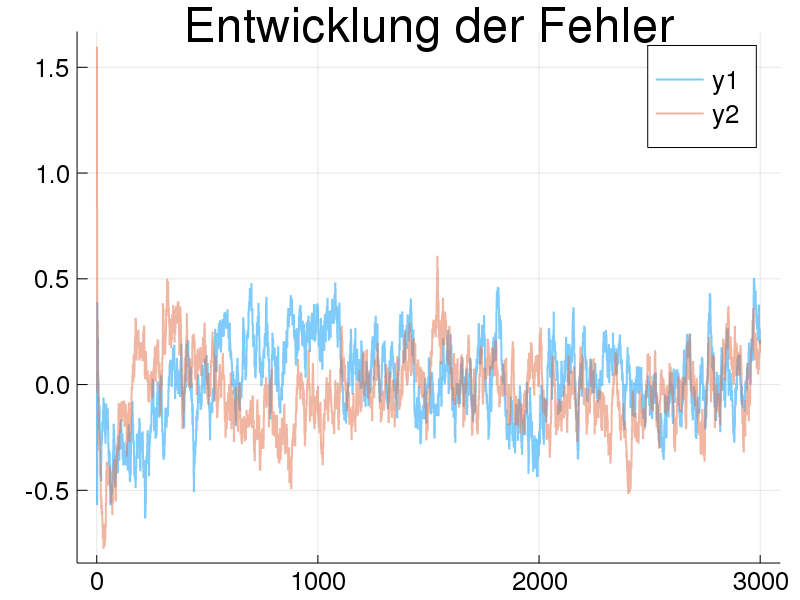

In [208]:
@show sum(abs.(generated_output.aX - generated_data.True_a_x))
plot(title = "Entwicklung der Fehler", generated_output.Id, [generated_output.aX - generated_data.True_a_x generated_output.aY - generated_data.True_a_y])

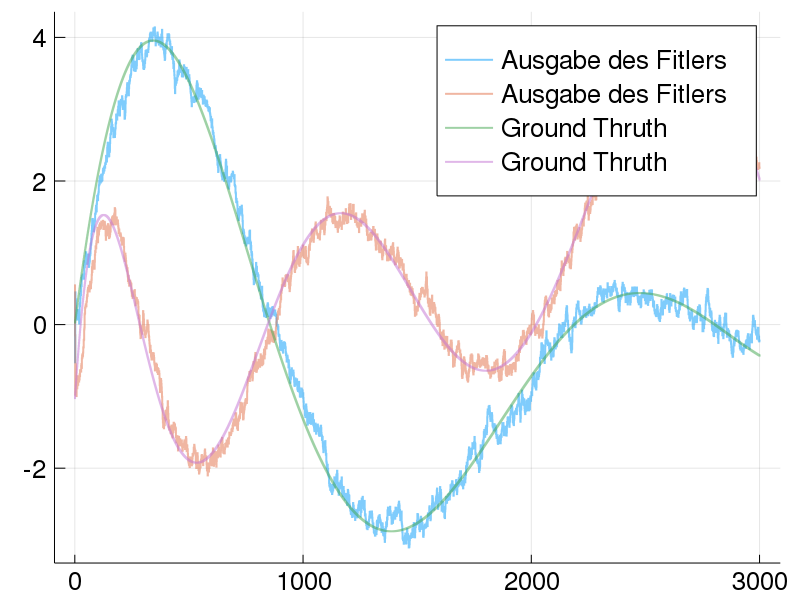

In [209]:
@df generated_output begin
    plot()
    plot!(:Id, [:aX :aY], label = "Ausgabe des Fitlers")
    plot!(generated_data.Id, [generated_data.True_a_x generated_data.True_a_y], label = "Ground Thruth")
end

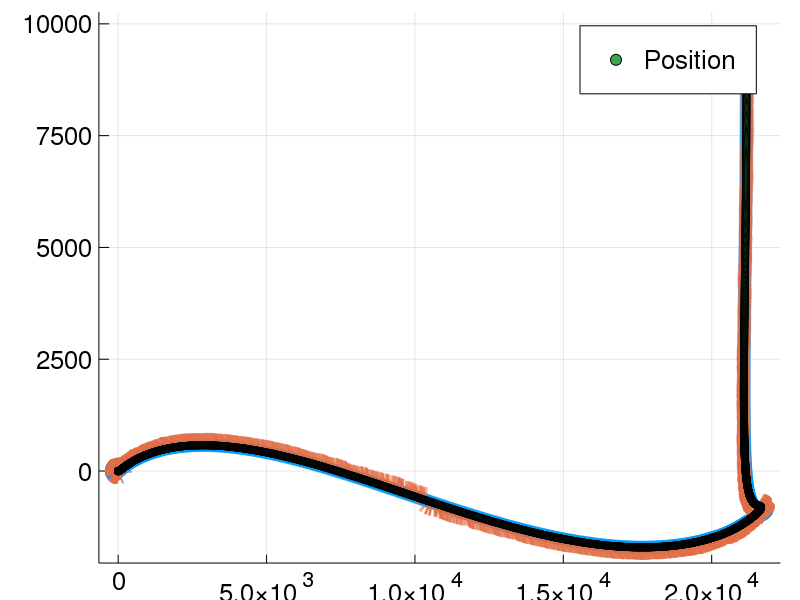

In [210]:
p = plot()
@df generated_output begin
    quiver!(:pX, :pY, quiver=(:vX, :vY), label = "Geschwindigkeit")
    quiver!(:pX, :pY, quiver=(:aX, :aY))
    scatter!(:pX, :pY, label = "Position")
    scatter!()
end
png("plot-2d-motion.png")
p

In [211]:
@which @df

ErrorException: no unique matching method found for the specified argument types

### Anwendung des Modells auf echte Daten


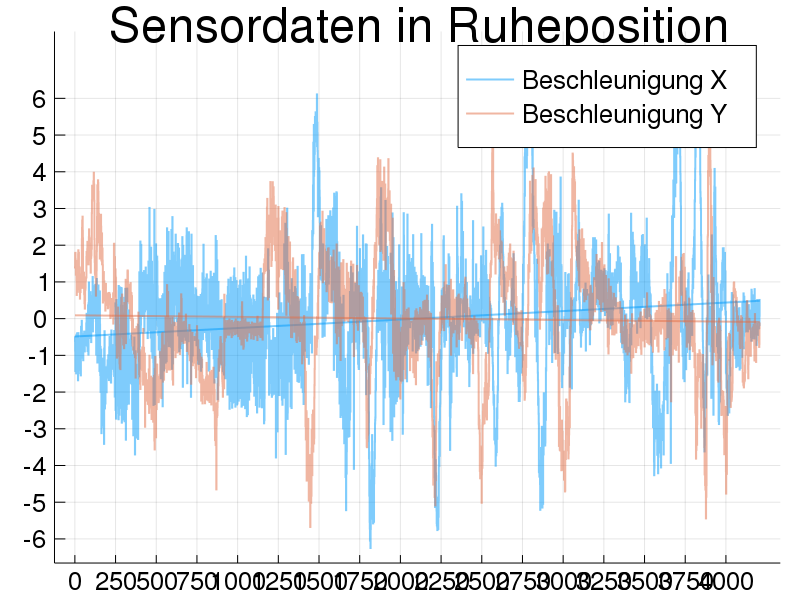

In [212]:
function preprocess(sensor) 
    for c = [:Gyro_x, :Gyro_y, :Gyro_z, :Accel_z]
        deletecols!(sensor, c)
    end
    sensor[:Id] = 1:size(sensor)[1]
    sensor.Accel_x = (sensor[:Accel_x] .- mean(sensor.Accel_x)) .* 2
    sensor.Accel_y = (sensor[:Accel_y] .- mean(sensor.Accel_y)) .* 2
end
sensor_real = CSV.File("./SensorTracker_20190405_174228.csv", delim = ";", dateformat = DateFormat("yyyymmdd_HHMMss")) |> DataFrame
preprocess(sensor_real)
plot(title = "Sensordaten in Ruheposition", yticks = -6:6, xticks = 0:250:4000)
plot!(sensor_real.Id, [sensor_real.Accel_x sensor_real.Accel_y], smooth = true, label = ["Beschleunigung X", "Beschleunigung Y"])

In [213]:
n = size(sensor_real)[1]
fusioned = zeros(Float64, 7, n)
for i = eachrow(sensor_real)    
    y_cur = [i.Accel_x; i.Accel_y]
    neu = KalmanFilter.next(model, y_cur)
    fusioned[:, i.Id] = [neu.fusioned..., i.Id]
    model = neu.model
end

output = DataFrame(fusioned', [:pX, :pY, :vX, :vY, :aX, :aY, :Id])
describe(output)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Nothing,Nothing,DataType
1,pX,13841.9,6828.0,14369.3,21174.5,,,Float64
2,pY,63939.7,9689.86,62925.5,1.20182e5,,,Float64
3,vX,-33.9136,-69.818,-32.7512,7.21521,,,Float64
4,vY,262.661,216.544,262.044,296.767,,,Float64
5,aX,-0.00149121,-3.9539,-0.0111668,5.43281,,,Float64
6,aY,0.011983,-3.57973,-0.144423,2.85163,,,Float64
7,Id,2104.5,1.0,2104.5,4208.0,,,Float64


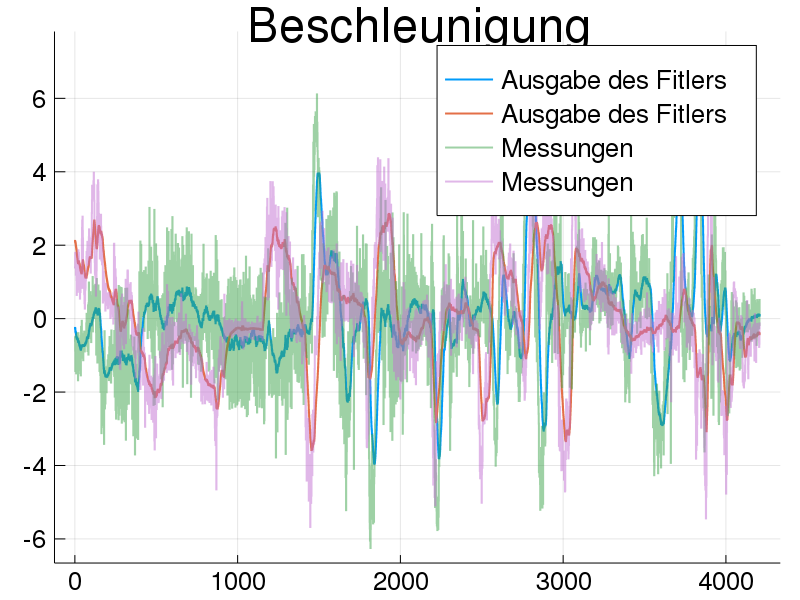

In [214]:
plot(title = "Beschleunigung")
plot!(output.Id, [output.aX output.aY], label = "Ausgabe des Fitlers", linealpha = 1.5, linewidth = 2)
plot!(sensor_real.Id, [sensor_real.Accel_x sensor_real.Accel_y], label = "Messungen")

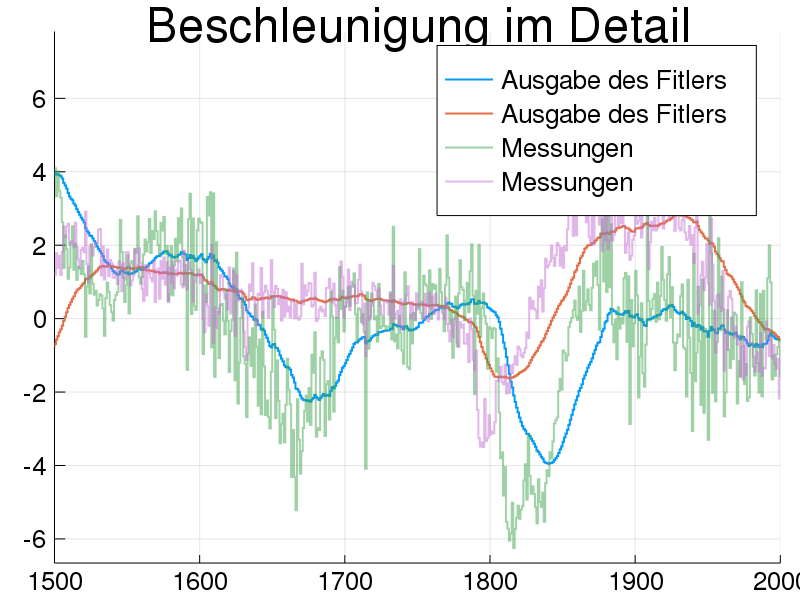

In [215]:
plot(title = "Beschleunigung im Detail", xlim = (1500, 2000))
plot!(output.Id, [output.aX output.aY], label = "Ausgabe des Fitlers", linealpha = 1.5, linewidth = 2)
plot!(sensor_real.Id, [sensor_real.Accel_x sensor_real.Accel_y], label = "Messungen")

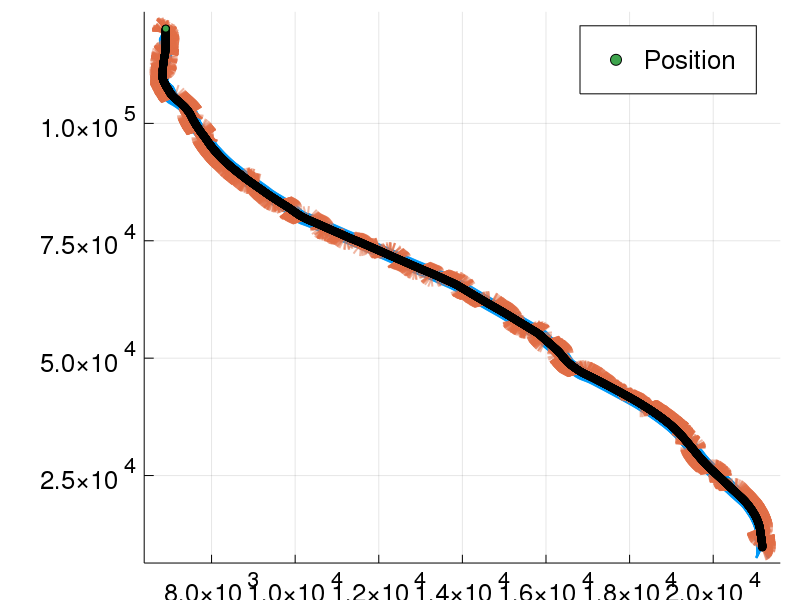

In [216]:
p = plot()
quiver!(output.pX, output.pY, quiver=(output.vX, output.vY), label = "Geschwindigkeit")
quiver!(output.pX, output.pY, quiver=(output.aX, output.aY))
scatter!(output.pX, output.pY, label = "Position")
png("plot-2d-motion.png")
p

## Erweiterung für Position
Für diese Aufgabe werden die Datensätze für Beschleunigung ohne Rauschen betrachtet und numerisch integriert.

In [217]:
prevSpeed = (x = 0, y = 0)
prevPos = (x = 0, y = 0)
new_data = zeros(4, size(generated_data)[1])
for row = eachrow(generated_data)
    speed = (x = prevSpeed.x + Δ_t * row.Accel_x, y = prevSpeed.y + Δ_t * row.Accel_y)
    pos = (x = prevPos.x + Δ_t * prevSpeed.x, y = prevPos.y + Δ_t * prevSpeed.y)
    new_data[:, row.Id] = [speed.x, speed.y, pos.x, pos.y]
    prevSpeed = speed
    prevPos = pos
end

new_data = DataFrame(
    :Speed_x => new_data[1, :], 
    :Speed_y => new_data[2, :], 
    :Pos_x => noise(new_data[3, :], 50), 
    :Pos_y => noise(new_data[4, :], 50),
    :True_pos_x => new_data[3, :],
    :True_pos_y => new_data[4, :]
);

In [218]:
@show size(generated_data)
generated_data = hcat(generated_data, new_data)
describe(generated_data)

size(generated_data) = (3001, 5)


,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Nothing,DataType
1,Id,1501.0,1,1501.0,3001,,,Int64
2,Accel_x,0.000538338,-5.67721,-0.129781,6.09369,,,Float64
3,Accel_y,0.854114,-4.4866,0.752072,6.70662,,,Float64
4,True_a_x,-0.0124523,-2.8792,-0.033387,3.95685,,,Float64
5,True_a_y,0.871319,-1.92377,0.789312,3.88162,,,Float64
6,Speed_x,70.5178,-14.8777,34.6539,211.158,,,Float64
7,Speed_y,32.3357,-48.0399,11.7934,256.32,,,Float64
8,Pos_x,14911.4,-130.738,20248.4,21753.7,,,Float64
9,Pos_y,272.625,-1814.24,-349.753,9734.65,,,Float64


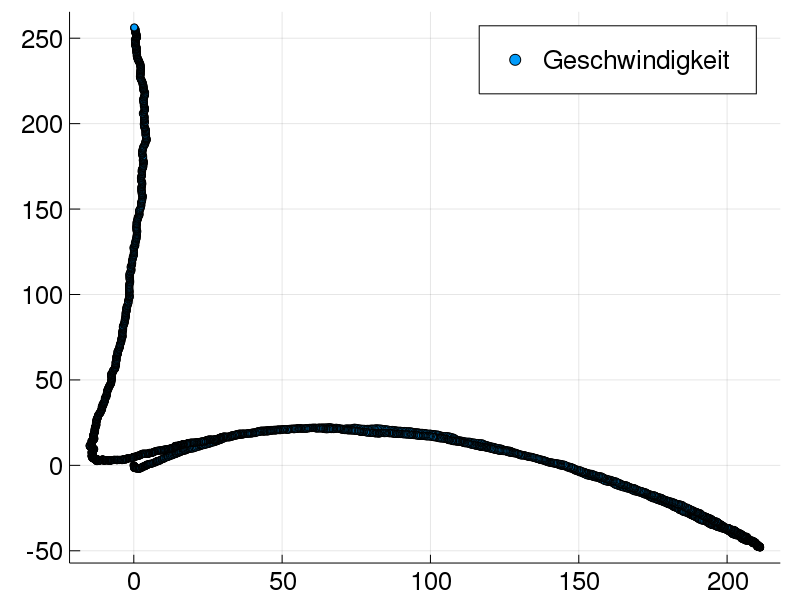

In [219]:
@df generated_data begin
    scatter(:Speed_x, :Speed_y, label = "Geschwindigkeit")
end

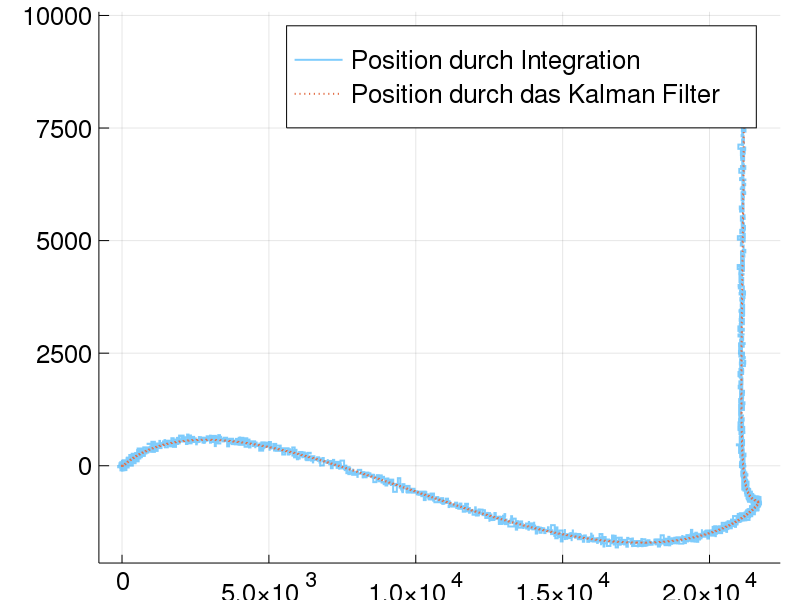

In [220]:
@df generated_data begin
    plot()
    plot!(:Pos_x, :Pos_y, label = "Position durch Integration")
    plot!(generated_output.pX, generated_output.pY, label = "Position durch das Kalman Filter", linestyle = :dot, linealpha = 1)
end

In [221]:
first(generated_data, 10)

,Id,Accel_x,Accel_y,True_a_x,True_a_y,Speed_x,Speed_y,Pos_x,Pos_y,True_pos_x,True_pos_y
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,0.0696956,0.560452,0.0156306,-1.03797,0.00696956,0.0560452,69.0589,32.2016,0.0,0.0
2,2,-1.11845,-0.856441,0.0401973,-0.989719,-0.104876,-0.0295989,0.10422,-34.0068,0.000696956,0.00560452
3,3,2.3836,-2.61533,0.0646838,-0.942052,0.133485,-0.291131,83.6695,-29.0102,-0.00979061,0.00264463
4,4,-0.120045,-0.185909,0.0890899,-0.894968,0.12148,-0.309722,2.60099,39.667,0.00355787,-0.0264685
5,5,-0.0605994,0.322076,0.113416,-0.848464,0.11542,-0.277515,-28.4145,-37.5026,0.0157059,-0.0574407
6,6,0.940494,-1.57859,0.137661,-0.802536,0.20947,-0.435373,53.3642,-54.0397,0.0272479,-0.0851922
7,7,-0.806371,-0.663499,0.161826,-0.757179,0.128833,-0.501723,-40.9715,-51.8315,0.0481949,-0.12873
8,8,0.296758,-2.84401,0.185911,-0.712391,0.158509,-0.786124,29.7816,61.6182,0.0610782,-0.178902
9,9,-0.685093,0.207635,0.209915,-0.668168,0.0899992,-0.765361,40.7795,-4.69426,0.076929,-0.257514


### Neue Messmatrix $ G $ für Positionsbestimmung

Wir messen nur die Beschleunigung $\ddot x$ und $\ddot y$ direkt.
Unsere Beobachtungsmodell ist $ y = Gx $:

$$
    y =
    \begin{pmatrix}
    1 & 0 & 0 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 & 0 & 0
    \end{pmatrix}
    *
    x
$$

Dazu wird nun die Messmatrix neu definiert.

In [222]:
x_0 = zeros(6, 1)
Σ_0 = Matrix{Float64}(I, 6, 6) .* 1000

Δ_t = 0.1 # Messfrequenz war 100ms
A = [1 0 Δ_t 0 0.5*Δ_t^2 0;
     0 1 0 Δ_t 0 0.5*Δ_t^2;
     0 0 1 0 Δ_t 0;
     0 0 0 1 0 Δ_t;
     0 0 0 0 1 0;
     0 0 0 0 0 1]

G = [0 0 0 0 1 0;
     0 0 0 0 0 1]

R = [0.4 0;
     0 0.4]

σ_v = 8.8
Gravity = transpose([ 0.5 * Δ_t^2 0.5 * Δ_t^2 Δ_t Δ_t Δ_t Δ_t])
#Q = transpose(Gravity * transpose(Gravity) * σ_v^2)
Q = I * 0.001

UniformScaling{Float64}
0.001*I

In [225]:
n = size(generated_data)[1]
fusioned = zeros(Float64, 7, n)
for i = eachrow(generated_data)    
    y_cur = [i.Pos_x; i.Pos_y]
    neu = KalmanFilter.next(model, y_cur)
    fusioned[:, i.Id] = [neu.fusioned..., i.Id]
    model = neu.model
end
output = DataFrame(fusioned', [:pX, :pY, :vX, :vY, :aX, :aY, :Id])
describe(output)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Nothing,Nothing,DataType
1,pX,3.77352e9,2.31187e9,3.70604e9,5.4808e9,,,Float64
2,pY,1.30214e7,-7.18963e6,1.67365e7,2.59441e7,,,Float64
3,vX,1.05633e7,8.94782e6,1.02365e7,1.34226e7,,,Float64
4,vY,1.10471e5,17613.9,1.1743e5,2.44782e5,,,Float64
5,aX,14911.4,66.0843,20102.7,21669.4,,,Float64
6,aY,272.625,-1720.43,-353.946,9190.94,,,Float64
7,Id,1501.0,1.0,1501.0,3001.0,,,Float64


sum(abs.(output.aX - generated_data.True_pos_x)) = 844350.5584259023


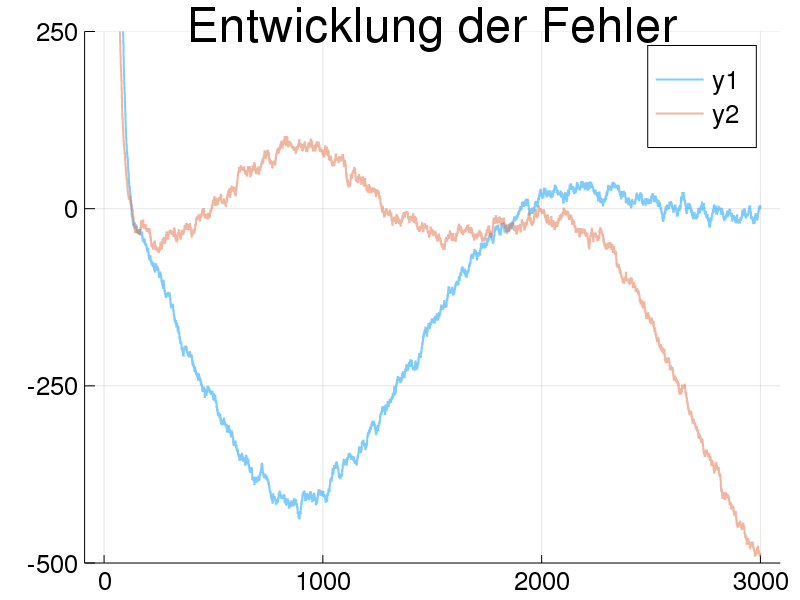

In [233]:
@show sum(abs.(output.aX - generated_data.True_pos_x))
plot(title = "Entwicklung der Fehler", ylim = (-500, 250))
plot!(output.Id, [output.aX - generated_data.True_pos_x output.aY - generated_data.True_pos_y])

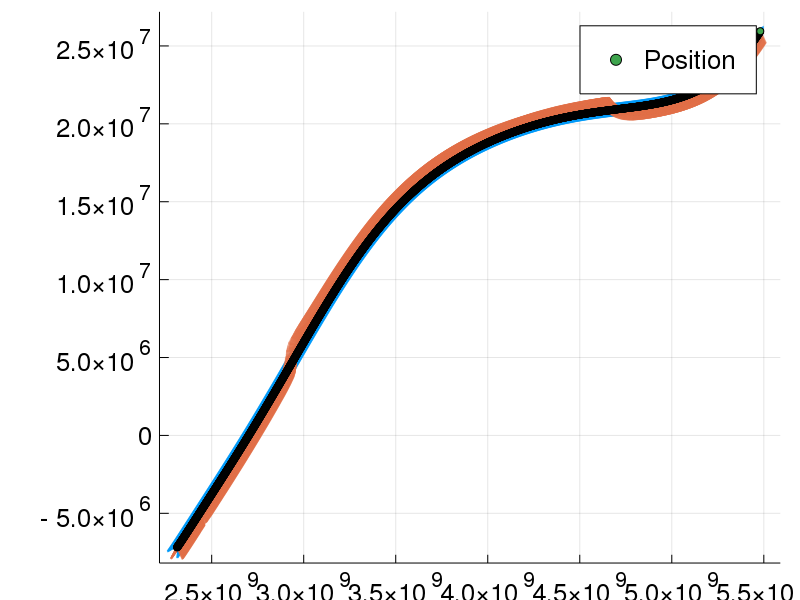

In [227]:
p = plot()
@df output begin
    quiver!(:pX, :pY, quiver=(:vX, :vY), label = "Geschwindigkeit")
    quiver!(:pX, :pY, quiver=(:aX, :aY))
    scatter!(:pX, :pY, label = "Position")
end
p